In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4584297117649299384,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3160127861489061235
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6669181490160014490,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14026407551680697557
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [6]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
imgs, labels =next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

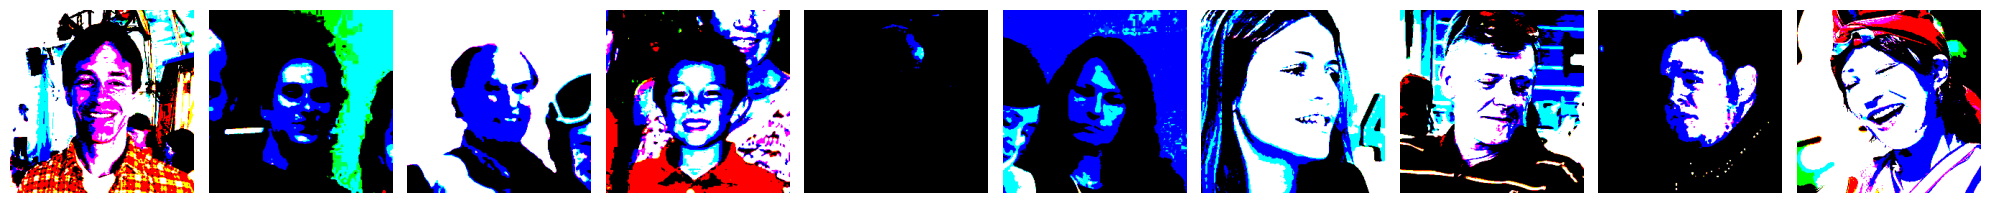

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

In [11]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(256,256,3)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.2),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6779219857998304942,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3342988664402278935
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [17]:
model.compile(loss="binary_crossentropy",optimizer=SGD(learning_rate = 0.0001, momentum=0.9), metrics=['binary_accuracy'])

In [18]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
14001/14001 [==============================] - 1956s 139ms/step - loss: 0.4608 - binary_accuracy: 0.7725 - val_loss: 0.4893 - val_binary_accuracy: 0.7868
Epoch 2/10
14001/14001 [==============================] - 1763s 126ms/step - loss: 0.2677 - binary_accuracy: 0.8872 - val_loss: 0.3141 - val_binary_accuracy: 0.8678
Epoch 3/10
14001/14001 [==============================] - 1633s 117ms/step - loss: 0.1947 - binary_accuracy: 0.9213 - val_loss: 0.2165 - val_binary_accuracy: 0.9083
Epoch 4/10
14001/14001 [==============================] - 1590s 114ms/step - loss: 0.1603 - binary_accuracy: 0.9347 - val_loss: 0.2240 - val_binary_accuracy: 0.9052
Epoch 5/10
14001/14001 [==============================] - 1559s 111ms/step - loss: 0.1386 - binary_accuracy: 0.9443 - val_loss: 0.2000 - val_binary_accuracy: 0.9162
Epoch 6/10
14001/14001 [==============================] - 1551s 111ms/step - loss: 0.1269 - binary_accuracy: 0.9491 - val_loss: 0.1730 - val_binary_accuracy: 0.9285
Epoch 7/10

In [19]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

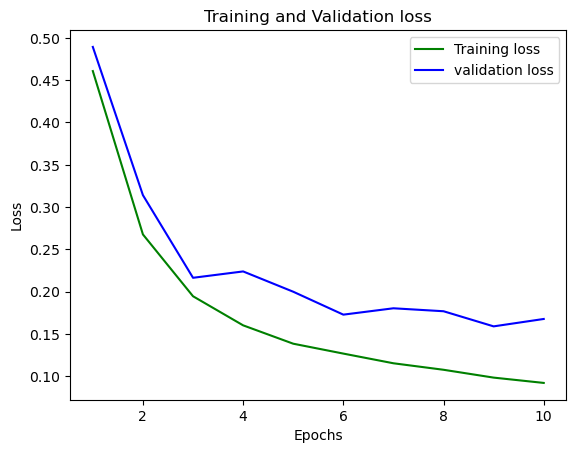

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

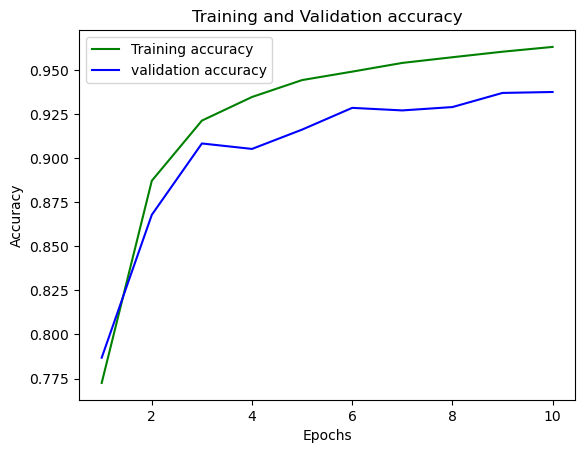

In [21]:
loss = history.history['binary_accuracy']
val_loss = history.history['val_binary_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model.metrics_names

['loss', 'binary_accuracy']

In [23]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 107s 98ms/step


In [24]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [25]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [26]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [27]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[3182 2310]
 [3169 2244]]


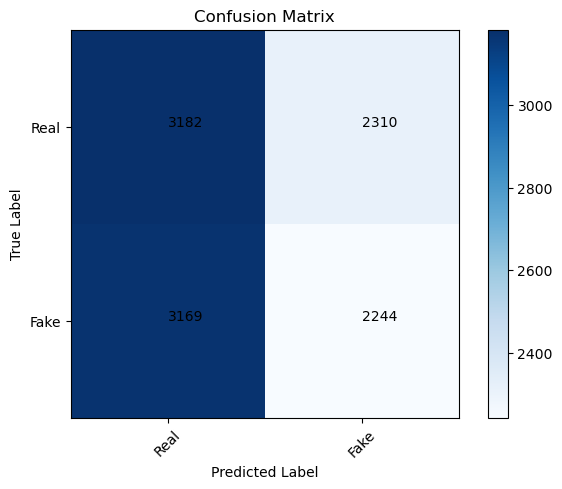

In [28]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [29]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\DF.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

In [30]:
from sklearn.metrics import accuracy_score, classification_report

In [31]:
#classification_report(test_batches.classes , np.round(predictions))